In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
train_data_dir = 'DataSet\Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Acer\AppData\Local\Temp\ipykernel_25108\3765618846.py:1: SyntaxWarning: invalid escape sequence '\T'
  train_data_dir = 'DataSet\Training'


In [30]:
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis=1)

In [31]:
test_data_dir = 'DataSet\Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Acer\AppData\Local\Temp\ipykernel_25108\2514046976.py:1: SyntaxWarning: invalid escape sequence '\T'
  test_data_dir = 'DataSet\Testing'


In [32]:
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis=1)

In [33]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)

In [34]:
classes = sorted(list(set(labels)))

In [35]:
class_weights = compute_class_weight('balanced', classes=np.array(classes), y=train_df['labels'].values)
class_weight_dict = dict(enumerate(class_weights))

In [36]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [37]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [38]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [39]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [40]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(classes), activation='softmax')
])

In [41]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)



In [43]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.4621 - loss: 1.1776 - val_accuracy: 0.8556 - val_loss: 0.4374 - learning_rate: 1.0000e-04
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.7926 - loss: 0.5608 - val_accuracy: 0.8749 - val_loss: 0.3470 - learning_rate: 1.0000e-04
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.8492 - loss: 0.4374 - val_accuracy: 0.8793 - val_loss: 0.3916 - learning_rate: 1.0000e-04
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 364s 3s/step - accuracy: 0.8704 - loss: 0.3765 - val_accuracy: 0.9090 - val_loss: 0.2709 - learning_rate: 1.0000e-04
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.8944 - loss: 0.3204 - val_accuracy: 0.9029 - val_loss: 0.2817 - learning_rate: 1.0000e-04
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - accuracy: 0.8798 - loss: 0.3444 - val_accuracy: 0.8950 - val_loss: 0.3191 - learning_rate: 1.0000e-04
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - acc

In [51]:
# Assuming your trained model is named 'model'
model.save('vgg19_brain_tumor_model.h5')
print("Model saved as vgg19_model.h5")

Model saved as vgg19_model.h5


In [44]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.8690 - loss: 0.3398
Test Accuracy: 0.9130


In [45]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred_classes, target_names=classes))


41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step
              precision    recall  f1-score   support

      glioma       0.97      0.82      0.89       300
  meningioma       0.86      0.85      0.86       306
     notumor       0.95      0.98      0.96       405
   pituitary       0.87      0.99      0.92       300

    accuracy                           0.91      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.92      0.91      0.91      1311



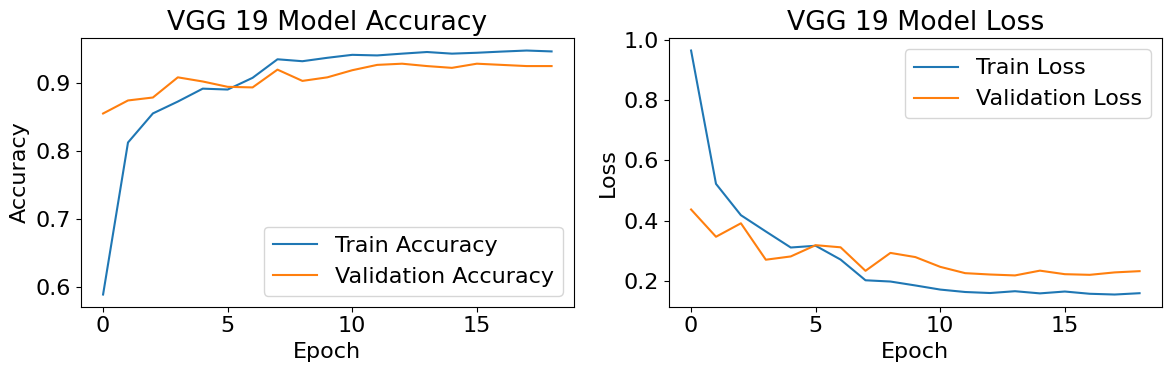

In [55]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG 19 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VGG 19 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import sys

class BrainTumorGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Brain Tumor Classification")
        self.root.geometry("1000x700")

        # Configure model paths
        self.vgg19_model_path = 'vgg19_brain_tumor_model.h5'
        self.other_model_path = 'full_model.pth'

        # Load the VGG19 model
        try:
            self.vgg19_model = tf.keras.models.load_model(self.vgg19_model_path)
            print("VGG19 model loaded successfully.")
        except FileNotFoundError:
            messagebox.showerror("Error", f"VGG19 model file not found at {self.vgg19_model_path}.")
            self.root.destroy()
            return
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load VGG19 model: {e}")
            self.root.destroy()
            return

        # Load the EfficientNet model
        try:
            self.other_model = tf.keras.models.load_model(self.other_model_path)
            print("EfficientNet model loaded successfully.")
        except FileNotFoundError:
            messagebox.showerror("Error", f"EfficientNet model file not found at {self.other_model_path}.")
            self.root.destroy()
            return
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load EfficientNet model: {e}")
            self.root.destroy()
            return

        # Class labels
        self.classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

        # GUI components
        self.label_title = tk.Label(root, text="Brain Tumor MRI Classifier", font=("Arial", 16, "bold"))
        self.label_title.pack(pady=10)

        self.canvas = tk.Canvas(root, width=400, height=400, bg="white")
        self.canvas.pack(pady=10)

        self.btn_select = tk.Button(root, text="Select MRI Image", command=self.select_image)
        self.btn_select.pack(pady=5)

        self.btn_predict_vgg19 = tk.Button(root, text="Predict with VGG19", command=self.predict_vgg19, state=tk.DISABLED)
        self.btn_predict_vgg19.pack(pady=5)

        self.btn_predict_other = tk.Button(root, text="Predict with EfficientNet", command=self.predict_other, state=tk.DISABLED)
        self.btn_predict_other.pack(pady=5)

        self.label_result = tk.Label(root, text="", font=("Arial", 12))
        self.label_result.pack(pady=10)

        # Image variables
        self.image_path = None
        self.photo = None

    def select_image(self):
        self.image_path = filedialog.askopenfilename(
            filetypes=[("Image files", "*.jpg *.jpeg *.png")]
        )
        if self.image_path:
            try:
                img = Image.open(self.image_path)
                img = img.resize((400, 400), Image.Resampling.LANCZOS)
                self.photo = ImageTk.PhotoImage(img)
                self.canvas.create_image(200, 200, image=self.photo)
                self.btn_predict_vgg19.config(state=tk.NORMAL)
                self.btn_predict_other.config(state=tk.NORMAL)
                self.label_result.config(text="")
                print(f"Image loaded: {self.image_path}")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to load image: {e}")
                self.image_path = None
                self.btn_predict_vgg19.config(state=tk.DISABLED)
                self.btn_predict_other.config(state=tk.DISABLED)

    def predict_vgg19(self):
        if not self.image_path:
            messagebox.showwarning("Warning", "Please select an image first!")
            return

        try:
            print(f"Predicting with VGG19 for image: {self.image_path}")
            img = load_img(self.image_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = img_array / 255.0

            prediction = self.vgg19_model.predict(img_array)
            print(f"VGG19 prediction raw output: {prediction}")
            predicted_class = self.classes[np.argmax(prediction[0])]
            confidence = np.max(prediction[0]) * 100

            self.label_result.config(
                text=f"Predicted: {predicted_class} (Confidence: {confidence:.2f}%) - VGG19"
            )
            print(f"VGG19 Result: {predicted_class} ({confidence:.2f}%)")
        except Exception as e:
            messagebox.showerror("Error", f"VGG19 prediction failed: {e}")
            print(f"VGG19 prediction error: {e}")

    def predict_other(self):
        if not self.image_path:
            messagebox.showwarning("Warning", "Please select an image first!")
            return

        try:
            print(f"Predicting with EfficientNet for image: {self.image_path}")
            img = load_img(self.image_path, target_size=(240, 240))  # Adjust dimensions here
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = img_array / 255.0

            prediction = self.other_model.predict(img_array)
            print(f"EfficientNet prediction raw output: {prediction}")
            predicted_class = self.classes[np.argmax(prediction[0])]
            confidence = np.max(prediction[0]) * 100

            self.label_result.config(
               text=f"Predicted: {predicted_class} (Confidence: {confidence:.2f}%) - EfficientNet"
            )
            print(f"EfficientNet Result: {predicted_class} ({confidence:.2f}%)")
        except Exception as e:
            messagebox.showerror("Error", f"EfficientNet prediction failed: {e}")
            print(f"EfficientNet prediction error: {e}")

if __name__ == "__main__":
    root = tk.Tk()
    app = BrainTumorGUI(root)
    root.mainloop()

VGG19 model loaded successfully.
